Offset Gyroscope
 
This notebook reproduces a symbolic and numerical simulation of an offset Gyroscope system using Python.
We use `SymPy` for symbolic computation and `SciPy` for solving the ODE numerically.   $\psi$ :  nutation angle ;    $\dot{\phi}$ :  precession and  $\dot {\theta}$ :  spin.

<img src="ELAG_HandNotizen/ELAG_seite1.png" alt="Bild 1" width="300"/>
<img src="ELAG_HandNotizen/ELAG_seite2.png" alt="Bild 2" width="300"/>
<img src="ELAG_HandNotizen/ELAG_seite3.png" alt="Bild 2" width="300"/>

In [120]:
# Imports
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sympy.printing.latex import latex
from IPython.display import display, Math

1. Symbolic Definitions

Define parameters, initial angular velocities and angular velocities as symbolic variables.

In [121]:
# Symbolic definitions
g, m, R, l = sp.symbols('g m R l', positive=True)
psi_0, psi_dot_0, phi_dot_0, theta_dot_0 = sp.symbols('psi_0 psi_dot_0 phi_dot_0 theta_dot_0', real=True)
psi, psi_dot, phi_dot, theta_dot = sp.symbols('psi psi_dot phi_dot theta_dot', real=True)

Define expressions for the variables of kinetic and potential energy such as position $\vec{r_s}$, hight $h_s$ velocity $\vec{v_s}$ and inertia matix $\Theta_s$ of the center of mass and also angular velocity vektor $\vec{\omega}$.

$r_s  =  \begin{pmatrix} l \\ 0 \\ 0 \end{pmatrix}  \qquad  h_s  =  -sin(\psi)  \cdot  l  \qquad  \vec{\omega}  =  \begin{pmatrix}  \dot{\theta}  -  sin(\psi)  \dot{\phi}  \\  \dot{\psi}  \\  cos(\psi)  \dot{\phi}  \end{pmatrix}  \qquad  \vec{v_s}  =  \vec{\omega}  \cdot  \vec{r_s}  \qquad  \Theta_s  =  \frac{1}{4}  m  R^2  \begin{pmatrix}  2  &  0  &  0  \\  0  &  1  &  0  \\  0  &  0  &  1  \end{pmatrix}$

In [122]:
# Position and velocity
h = -l * sp.sin(psi)
r_s = sp.Matrix([l, 0, 0])
omega = sp.Matrix([theta_dot - sp.sin(psi) * phi_dot, psi_dot, sp.cos(psi) * phi_dot])
Traegheitsmoment_s = 0.25 * m * R**2 * sp.Matrix([[2, 0, 0], [0, 1, 0], [0, 0, 1]])
v_s = omega.cross(r_s)

Compute the Lagrangian function.

$U  =  mgh  \qquad  T  =  \frac{1}{2}  \vec{v_s}  \cdot  m  \vec{v_s}  +  \frac{1}{2}  \vec{\omega}  \cdot    \Theta_s  \vec{\omega}  \qquad  \mathcal{L}  =  T  -  U$

In [123]:
# Energies
E_pot = m * g * h
E_kin = 0.5 * m * v_s.dot(v_s) + 0.5 * omega.dot(Traegheitsmoment_s * omega)
Lagrangian = E_kin - E_pot

# Display Lagrangian
L_latex = latex(Lagrangian)

L_latex = L_latex.replace(latex(psi_dot), r'\dot{\psi}')
L_latex = L_latex.replace(latex(phi_dot), r'\dot{\phi}')
L_latex = L_latex.replace(latex(theta_dot), r'\dot{\theta}')

display(Math(r"\mathcal{L} = " + L_latex))

<IPython.core.display.Math object>

2. Euler-Lagrange Equation

Compute canonical moments conjugate to generalised coordinates. Than apply conservation of canonical moments conjugate to those coordinates, for which Lagrangian has continuous symmetrie (in this case $\phi$ and $\theta$).


$\Pi_i  =  \frac{d}{d\dot{q}_i}  \mathcal{L}  \qquad  q_i  =\  \psi,\  \phi,\  \theta.$

$\frac{d}{dt}  \Pi_\phi  =  0  \qquad  \frac{d}{dt}  \Pi_\theta  =  0$

In [124]:
# Partial Derivatives
L_psi = sp.diff(Lagrangian, psi_dot)
L_phi = sp.diff(Lagrangian, phi_dot)
L_theta = sp.diff(Lagrangian, theta_dot)

# Substitute initial conditions
L_phi_0 = L_phi.subs({psi: psi_0, phi_dot: phi_dot_0, theta_dot: theta_dot_0})
L_theta_0 = L_theta.subs({psi: psi_0, phi_dot: phi_dot_0, theta_dot: theta_dot_0})

# Solve for phi_dot and theta_dot symbolically
sol = sp.solve([sp.Eq(L_phi, L_phi_0), sp.Eq(L_theta, L_theta_0)], [phi_dot, theta_dot], dict=True)
phi_dot_sym = sol[0][phi_dot]
theta_dot_sym = sol[0][theta_dot]

Compute Euler-Lagrange equation for $\psi$ and subsitute the angular velocities ${\dot{\phi}}$ and ${\dot{\theta}}$.

$\frac{d}{dt}  \Pi_\psi  =  \frac{d}{d\psi}  \mathcal{L}$

In [125]:
# Psi equation of motion
DLagrangian_Dpsi = sp.diff(Lagrangian, psi)
DLagrangian_Ddpsi_dt = sp.symbols('DLagrangian_Ddpsi_dt')
Drall_psi = sp.Eq(L_psi, DLagrangian_Ddpsi_dt)
psi_ddot = sp.solve(Drall_psi, psi_dot)[0]
psi_ddot_sym = psi_ddot.subs(DLagrangian_Ddpsi_dt, DLagrangian_Dpsi.subs({phi_dot: phi_dot_sym, theta_dot: theta_dot_sym}))

4. Parameters

Define numerical parameters and initial conditions.

In [126]:
g0 = 9.81 # m/s^2
m0 = 10 # kg
R0 = 0.125 # m
l0 = R0 # m
psi_00 = 0 # rad
psi_dot_00 = 0 # rad/s
phi_dot_00 = 0 # rad/s
theta_dot_00 = 10 * 2 * np.pi # rad/s
T = 1 # total time in seconds

param_subs = {g: g0, m: m0, R: R0, l: l0,
              psi_0: psi_00, psi_dot_0: psi_dot_00,
              phi_dot_0: phi_dot_00, theta_dot_0: theta_dot_00}

# Subsitute parameters into symbolic expressions for psi_ddot, phi_dot, and theta_dot
psi_ddot_p = psi_ddot_sym.subs(param_subs)
phi_dot_p = phi_dot_sym.subs(param_subs)
theta_dot_p = theta_dot_sym.subs(param_subs)

# Convert symbolic functions to numerical functions
psi_ddot_num = sp.lambdify(psi, psi_ddot_p, 'numpy')
phi_dot_num = sp.lambdify(psi, phi_dot_p, 'numpy')
theta_dot_num = sp.lambdify(psi, theta_dot_p, 'numpy')

5. ODE System

Define the ODE function and solve it numerically using `solve_ivp`.

In [127]:
def ode(t, y):
    psi_val = y[0]
    return [y[1],
            psi_ddot_num(psi_val),
            phi_dot_num(psi_val),
            theta_dot_num(psi_val)]

y0 = [psi_00, psi_dot_00, 0, 0]
t_span = (0, T)

sol = solve_ivp(ode, t_span, y0, t_eval=np.linspace(0, T, 500))

t = sol.t
psi_sol = sol.y[0]
psi_dot_sol = sol.y[1]
phi_sol = sol.y[2]
theta_sol = sol.y[3]
phi_dot_sol = phi_dot_num(psi_sol)
theta_dot_sol = theta_dot_num(psi_sol)

6. Plots

Plot $\psi(t)$,  $\phi(t)$,  $\theta(t)$ and their derivatives.

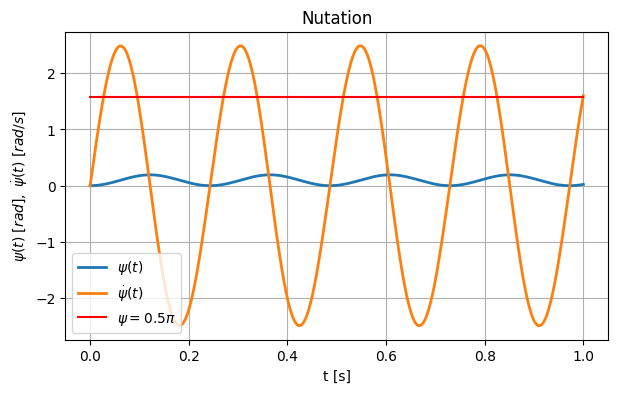

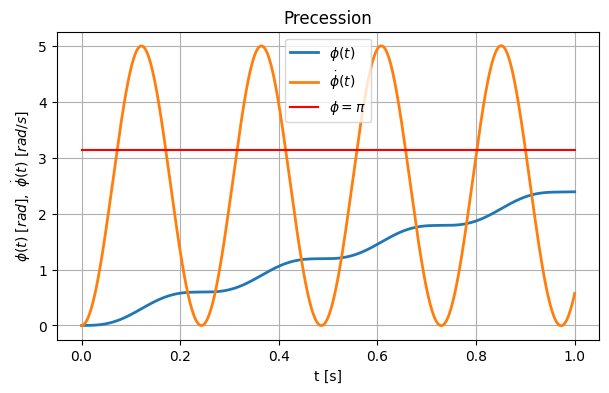

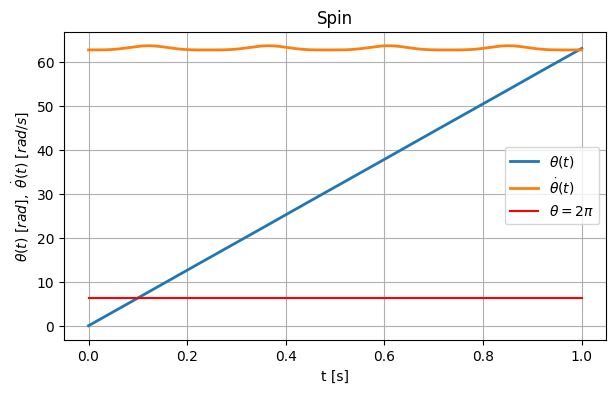

In [128]:
const = 0.5 * np.pi * np.ones_like(t)

# Psi plot
plt.figure(figsize=(7,4))
plt.plot(t, psi_sol, linewidth=2)
plt.plot(t, psi_dot_sol, linewidth=2)
plt.plot(t, const, 'r')
plt.xlabel('t [s]')
plt.ylabel(r'$\psi(t)\ [rad],\  \dot{\psi}(t)\ [rad/s]$')
plt.title(r'Nutation')
plt.legend([r'$\psi(t)$', r'$\dot{\psi}(t)$', r'$\psi = 0.5\pi$'], loc='best')
plt.grid(True)

# Phi plot
plt.figure(figsize=(7,4))
plt.plot(t, phi_sol, linewidth=2)
plt.plot(t, phi_dot_sol, linewidth=2)
plt.plot(t, 2*const, 'r')
plt.xlabel('t [s]')
plt.ylabel(r'$\phi(t)\ [rad],\  \dot{\phi}(t)\ [rad/s]$')
plt.title(r'Precession')
plt.legend([r'$\phi(t)$', r'$\dot{\phi}(t)$', r'$\phi = \pi$'], loc='best')
plt.grid(True)

# Theta plot
plt.figure(figsize=(7,4))
plt.plot(t, theta_sol, linewidth=2)
plt.plot(t, theta_dot_sol, linewidth=2)
plt.plot(t, 4*const, 'r')
plt.xlabel('t [s]')
plt.ylabel(r'$\theta(t)\ [rad],\  \dot{\theta}(t)\ [rad/s]$')
plt.title(r'Spin')
plt.legend([r'$\theta(t)$', r'$\dot{\theta}(t)$', r'$\theta = 2\pi$'], loc='best')
plt.grid(True)

plt.show()

7. Phase Space Diagrams

Plot  $\ \dot\psi(\psi)\ ,\  \dot\phi(\phi)\ ,\  \dot\theta(\theta)$.

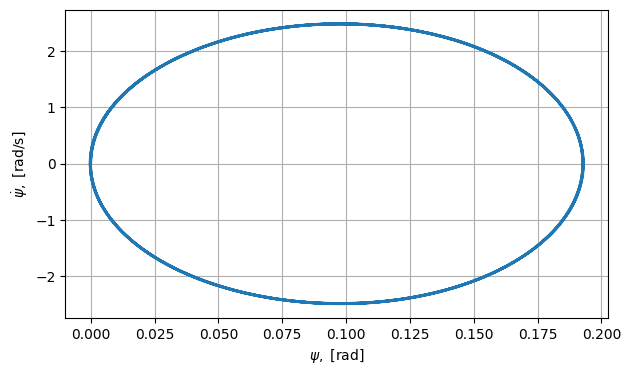

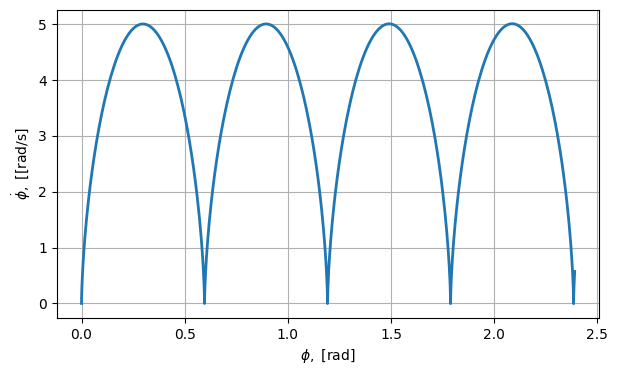

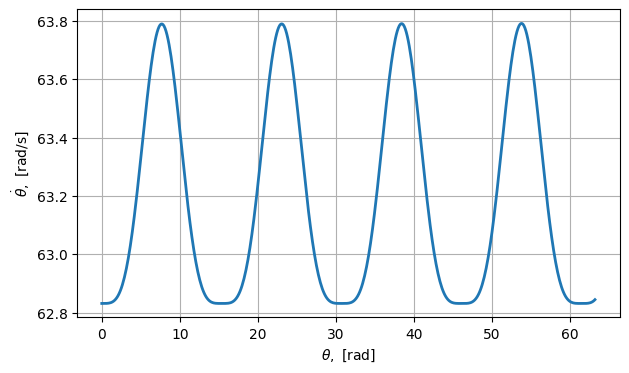

In [129]:
# Psi plot
plt.figure(figsize=(7,4))
plt.plot(psi_sol, psi_dot_sol, linewidth=2)
plt.xlabel(r'$\psi,\ [\mathrm{rad}]$')
plt.ylabel(r'$\dot{\psi},\ [\mathrm{rad/s}]$')
plt.grid(True)

# Phi plot
plt.figure(figsize=(7,4))
plt.plot(phi_sol, phi_dot_sol, linewidth=2)
plt.xlabel(r'$\phi,\ [\mathrm{rad}]$')
plt.ylabel(r'$\dot{\phi},\ [\mathrm{[rad/s}]$')
plt.grid(True)

# Theta plot
plt.figure(figsize=(7,4))
plt.plot(theta_sol, theta_dot_sol, linewidth=2)
plt.xlabel(r'$\theta,\ [\mathrm{rad}]$')
plt.ylabel(r'$\dot{\theta},\ [\mathrm{rad/s}]$')
plt.grid(True)

plt.show()

8. Analytical Solutions

Solution of Second-Order autonomous differential equation: $\ddot{\psi} = f(\psi)$

where $\psi = \psi(t)$ is a function of time, and $f(\psi)$ is a known function of $\psi$.

Reduce to First-Order Using Energy Method:  $\int  \ddot{\psi}  d\psi  = \int  f(\psi)  d\psi$

$d\psi  =  \dot{\psi}  dt
\qquad\Rightarrow\qquad
\int  \ddot{\psi}  d\psi  =  \int  \ddot{\psi}  \dot{\psi}  dt$

$d\dot{\psi}  =  \ddot{\psi} dt
\qquad\Rightarrow\qquad
\int  \dot{\psi}  \ddot{\psi}  dt  =  \int  \dot{\psi}  d\dot{\psi}$

thus:

$\frac{1}{2}  \dot{\psi}^2  - \frac{1}{2}  \dot{\psi_0}^2  =  \int_{\psi_0}^{\psi}  f(\psi)  d\psi
\qquad\Rightarrow\qquad
\dot{\psi}  =  \sqrt{  \dot{\psi_0}^2  +  2  \int_{\psi_0}^{\psi}  \ddot{\psi}(\psi)\  d\psi}$

Integrate for $\psi(t)$:

$dt  =  \frac{d\psi}{\dot{\psi}(\psi)}
\qquad\Rightarrow\qquad
t  =  \int_{\psi_0}^{\psi(t)}  \frac{d\psi}{\sqrt{  \dot{\psi_0}^2  +  2  \int_{\psi_0}^{\psi}  \ddot{\psi}(\psi)\  d\psi}}$

In [130]:
# Kinetic energy-based psi_dot function
deltaE_kin = sp.integrate(psi_ddot_p, psi)
deltaE_kin_p = deltaE_kin - deltaE_kin.subs(psi, psi_00)
psi_dot_p = sp.sqrt(psi_dot_00**2 + 2*deltaE_kin_p)

# Define symbolic function psi_fun
alpha = sp.symbols('alpha')

# Inverse for integration
DInvers_psi_Dpsi = 1 / psi_dot_p.subs(psi, alpha)

# Display as LaTeX
display(Math(r"\int \ddot{\psi}(\psi) d\psi = " + sp.latex(deltaE_kin)))
display(Math(r"t(\psi) = \int_{\psi_0}^{\psi}" + sp.latex(DInvers_psi_Dpsi) + r"d\alpha"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

9. Integration for  $\  \phi(\psi),\  \theta(\psi)$.
 
Compute the integrals:

$\dot{\phi}(\psi)  =  f_1(\psi)  \qquad\qquad  \dot{\theta}(\psi)  =  f_2(\psi)$

$\phi  =  \int f_1(\psi)  dt  \qquad\qquad  \theta  =  \int  f_2(\psi)  dt$

$dt  =  \frac{d\psi}{\dot{\psi}}  \qquad\Rightarrow\qquad  \phi  =  \int f_1(\psi)  \frac{d\psi}{\dot{\psi}}  \qquad\qquad  \theta  =  \int  f_2(\psi)  \frac{d\psi}{\dot{\psi}}$


 
$\phi(\psi)  =  \int  \frac{\dot{\phi}(\psi)}{\dot{\psi}(\psi)}  d\psi  \qquad\qquad  \theta(\psi)  =  \int  \frac{\dot{\theta}(\psi)}{\dot{\psi}(\psi)}  d\psi$

In [131]:
# phi(psi) and theta(psi)
Dphi_Dpsi = phi_dot_p / psi_dot_p
Dtheta_Dpsi = theta_dot_p / psi_dot_p

display(Math(r"\phi = \int_{\psi_0}^{\psi(t)}" + sp.latex(Dphi_Dpsi)))
display(Math(r"\theta = \int_{\psi_0}^{\psi(t)}" + sp.latex(Dtheta_Dpsi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>